# Image Processing

<p align = "center" style = "width: 60%;">
  <img src = "./data/img/roi_rondonia_amazonia.png">
</p>

In [1]:
import datetime
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from utils.Python.utils import Utils
from eocube import DataCube, Image, Spectral, info, config

config.ACCESS_TOKEN = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV"
utils = Utils()
spectral = Spectral()

In [3]:
info.collections()

stac("https://brazildatacube.dpi.inpe.br/stac/")

In [64]:
info.describe("S2_10_16D_STK-1")

name,common_name,min,max,nodata,scale,data_type
EVI,evi,-10000.0,10000.0,-9999.0,0.0001,int16
NDVI,ndvi,-10000.0,10000.0,-9999.0,0.0001,int16
TOTALOB,TotalOb,1.0,255.0,0.0,1.0,uint8
band4,red,0.0,10000.0,-9999.0,0.0001,int16
band1,coastal,0.0,10000.0,-9999.0,0.0001,int16
band11,swir16,0.0,10000.0,-9999.0,0.0001,int16
band12,swir22,0.0,10000.0,-9999.0,0.0001,int16
band2,blue,0.0,10000.0,-9999.0,0.0001,int16
band5,rededge,0.0,10000.0,-9999.0,0.0001,int16
band6,rededge,0.0,10000.0,-9999.0,0.0001,int16


https://www.keene.edu/campus/maps/tool/

In [113]:
%%time
eodatacube = DataCube(
    collections = ["S2_10_16D_STK-1"],
    query_bands = ['red', 'green', 'blue', 'nir', 'evi', 'quality'],
    bbox = [-65.335, -9.849, -63.641, -11.030],
    start_date = "2018-08-12",
    end_date = "2019-07-28",
    limit = 50
)

CPU times: user 183 ms, sys: 0 ns, total: 183 ms
Wall time: 6.95 s


In [114]:
dates = []
for date in list(eodatacube.data_images.keys()):
    dates.append(date.strftime("%Y-%m-%d"))
dates.reverse()
f"{len(dates)} images"

'24 images'

In [115]:
d = 2
evi = eodatacube.select(band="evi", time=dates[d])

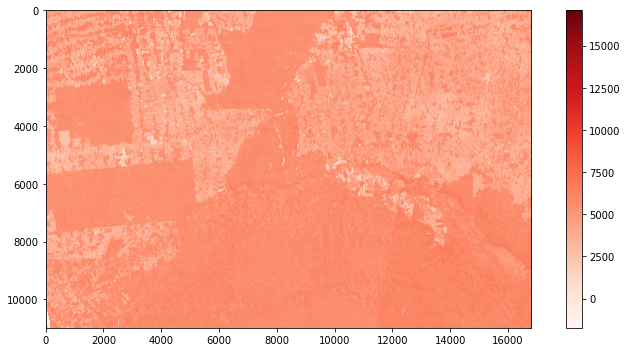

In [117]:
evi = evi.values[0]
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Reds', 1000)
plt.imshow(evi, cmap=colormap)
plt.tight_layout()
plt.colorbar()
plt.show()

In [109]:
ndvi = eodatacube.calculateNDVI(dates[d])

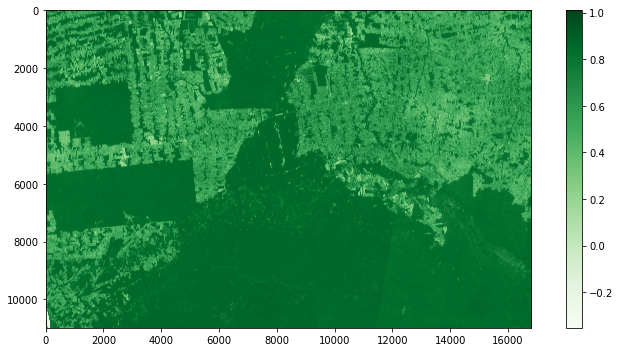

In [110]:
ndvi = ndvi.values[0]
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Greens', 1000)
plt.imshow(ndvi, cmap=colormap)
plt.tight_layout()
plt.colorbar()
plt.show()

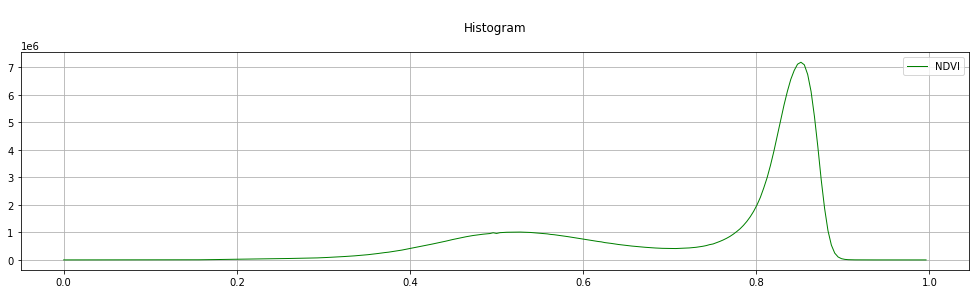

In [111]:
histogram, bin_edges = np.histogram(ndvi, bins=256, range=(0, 1))
plt.figure(figsize=(17,4))
plt.title(f"\nHistogram\n")
plt.plot(bin_edges[0:-1], histogram, color="green", linewidth=1, label='NDVI')
plt.legend()
plt.grid()
plt.show()

In [ ]:
red = eodatacube.select(band="red", time=dates[d])
green = eodatacube.select(band="green", time=dates[d])
blue = eodatacube.select(band="blue", time=dates[d])

In [47]:
red = red.values[0]
green = green.values[0]
blue = blue.values[0]
red_hist, red_bin_edges = np.histogram(red, bins=256)
green_hist, green_bin_edges = np.histogram(green, bins=256)
blue_hist, blue_bin_edges = np.histogram(blue, bins=256)

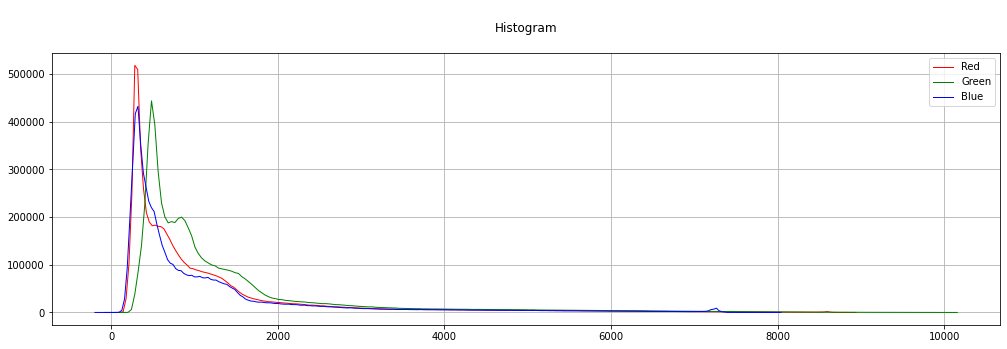

In [48]:
plt.figure(figsize=(17,5))
plt.title(f"\nHistogram\n")
plt.plot(red_bin_edges[0:-1], red_hist, color="red", linewidth=1, label='Red')
plt.plot(green_bin_edges[0:-1], green_hist, color="green", linewidth=1, label='Green')
plt.plot(blue_bin_edges[0:-1], blue_hist, color="blue", linewidth=1, label='Blue')
plt.legend()
plt.grid()
plt.show()

In [49]:
rgb = np.dstack(
    (Spectral()._normalize(red), Spectral()._normalize(green), Spectral()._normalize(blue))
)

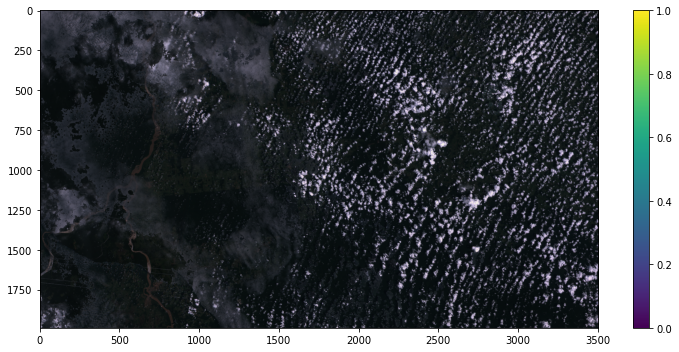

In [50]:
plt.figure(figsize=(10, 5))
plt.imshow(rgb)
plt.tight_layout()
plt.colorbar()
plt.show()

In [ ]:
# Renomear os arquivos de acordo com a configuração do SITS exemplo
# ./data/config.yml
utils.download_bands(
    eodatacube,
    path = "data/raster",
    satellite = "Sentinel-2",
    bands = ["NDVI", "EVI", "band4", "band3", "band2", "band8", "Fmask4"],
    start_date = "2018-08-12",
    end_date = "2019-07-28"
)